# **Load Data**

In [ ]:
!pip install findspark
!pip install pyspark

In [ ]:
from pyspark.sql import functions as f
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

def init_spark(app_name: str):
  spark = SparkSession.builder.appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc
  
spark, sc = init_spark('projectB')

df = spark.read.json("data.json")

# **Insight 1**

By using a Box Plot to visualize the X, Y, Z value range, we might find that every activity has a different value range.

For instance: stairsup and stairsdown are the only activities which have values above 2.5 on the y axies. 

In [ ]:
gt = ['stand', 'bike', 'sit', 'stand', 'walk', 'stairsup', 'stairsdown', 'null']
activity = []
x = []
y = []
z = []
for act in gt:
  xyz_vals = df.filter(f.col('gt') == act).select('x', 'y', 'z').collect()
  length = len(xyz_vals)
  for row in xyz_vals:
    x.append(row[0])
    y.append(row[1])
    z.append(row[2])
  activity += [act]*length
  # xyz = xyz + ['x']*length + ['y']*length + ['z']*length

sns.set_theme(style="whitegrid")
dict_data = {"Activity": activity, 'x': x, 'y': y, 'z': z}
plot_data = pd.DataFrame(dict_data)
sns.set(rc={'figure.figsize':(15,8)})

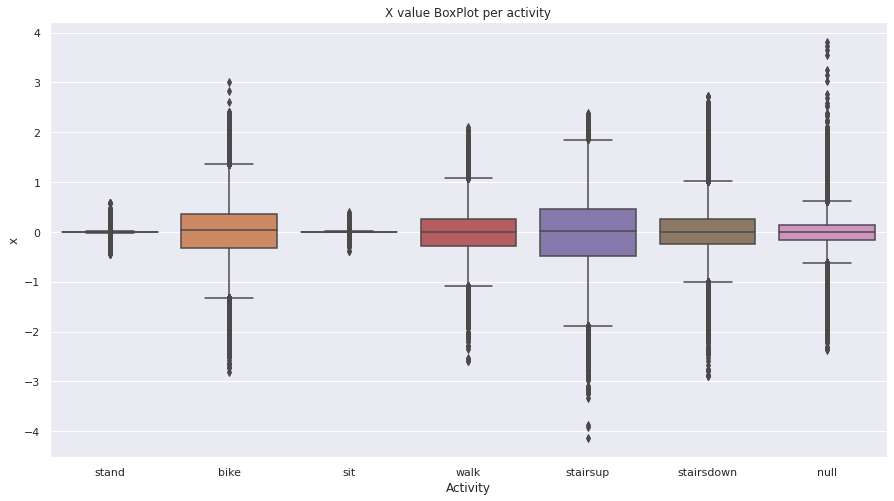

In [ ]:
plt = sns.boxplot(x="Activity", y="x",data=plot_data).set_title('X value BoxPlot per activity')

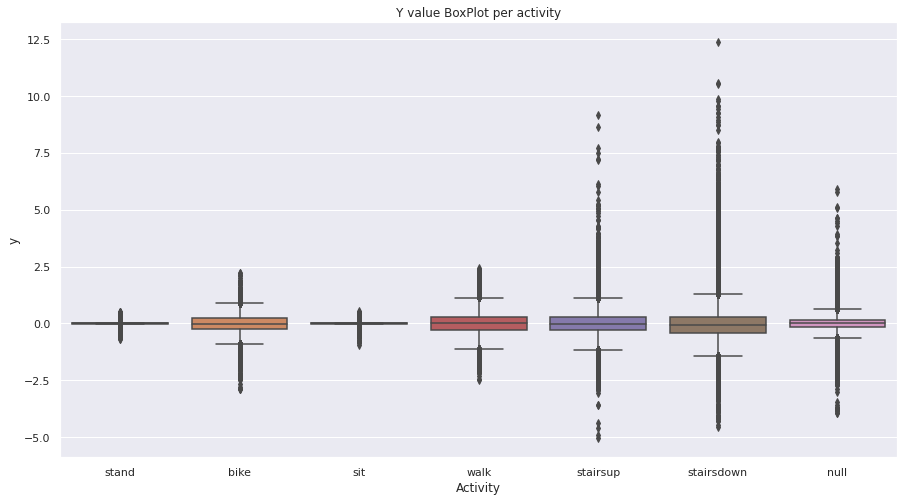

In [ ]:
plt = sns.boxplot(x="Activity", y="y",data=plot_data).set_title('Y value BoxPlot per activity')

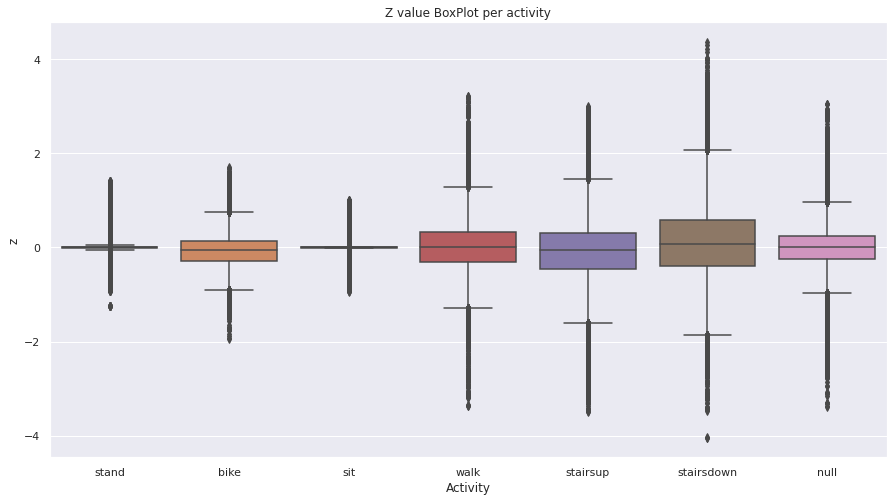

In [ ]:
plt = sns.boxplot(x="Activity", y="z",data=plot_data).set_title('Z value BoxPlot per activity')

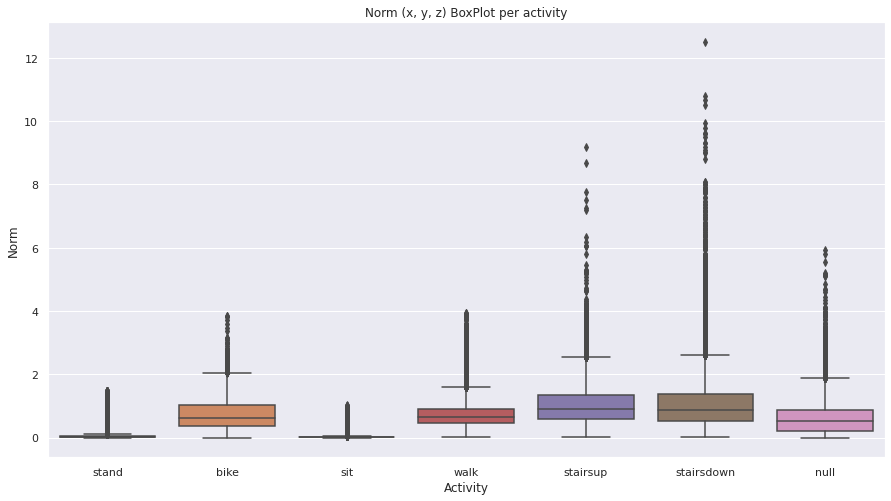

In [ ]:
norm_df = df.withColumn('norm', sum([f.col(j)**2 for j in ['x', 'y', 'z']])**0.5).select('gt', 'norm')
# norm_df.show()

gt = ['stand', 'bike', 'sit', 'stand', 'walk', 'stairsup', 'stairsdown', 'null']
activity = []
norm_val = []
for act in gt:
  vals = norm_df.filter(f.col('gt') == act).select('norm').collect()
  length = len(vals)
  for row in vals:
    norm_val.append(row[0])
  activity += [act]*length

sns.set_theme(style="whitegrid")
dict_data = {"Activity": activity, 'Norm': norm_val}
plot_data = pd.DataFrame(dict_data)
sns.set(rc={'figure.figsize':(15,8)})
plt = sns.boxplot(x="Activity", y="Norm",data=plot_data).set_title('Norm (x, y, z) BoxPlot per activity')

**Insight 1 concusion:**

Clearly we can conclude that the X, Y and Z values can help predict the activity which the user is performing or not performing.
From the last figure, We could derive easily that the majority of the Norm values for standing and sitting are below the the 25% percetile of the other activities. 
In a ML model, these values will contribute to the probabilty of classifing each data point as a certain activity.



# **Insight 2**

Checking if theres a difference in the duration in which each user performs each activity & the average duration of each activity performed by all users. 

In [ ]:
def plot_bar(title, data):

  # add title, drop the null bar

  plt.figure(figsize=(20, 5))
  plt.ylim((0,12))
  height = [data[x] for x in data]
  bars = tuple([x for x in data])

  y_pos = np.arange(len(bars))

  # Create bars
  plt.grid()
  plt.bar(y_pos, height)

  # Create names on the x-axis
  plt.xticks(y_pos, bars)

  plt.title(title, fontweight="bold")
  plt.show()


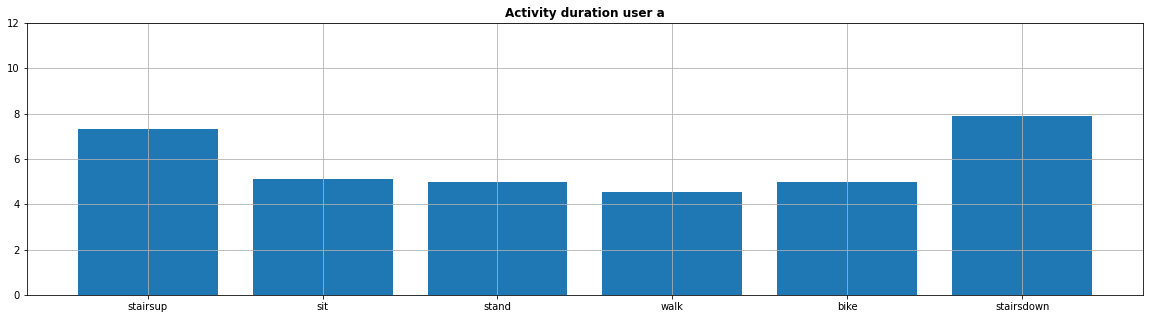

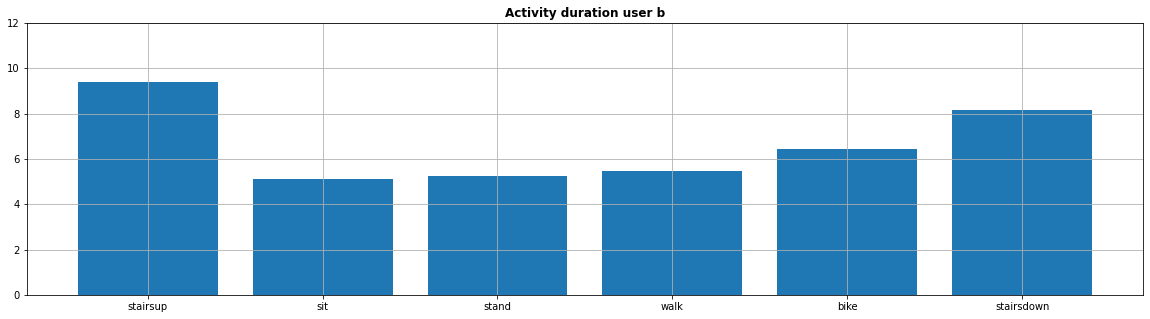

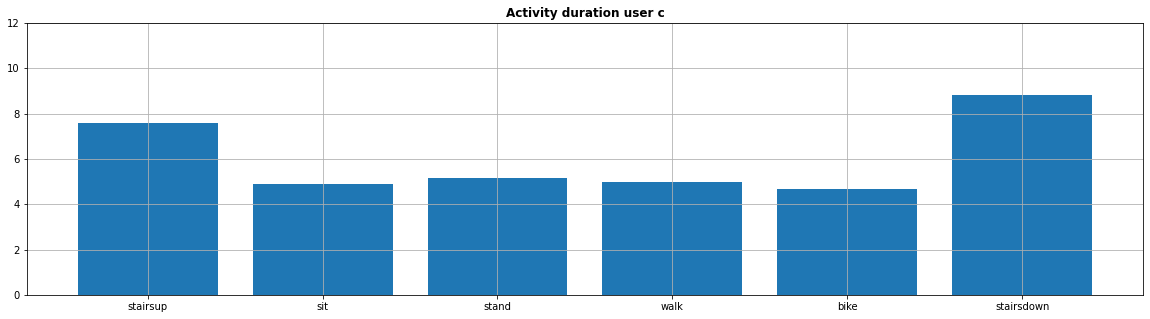

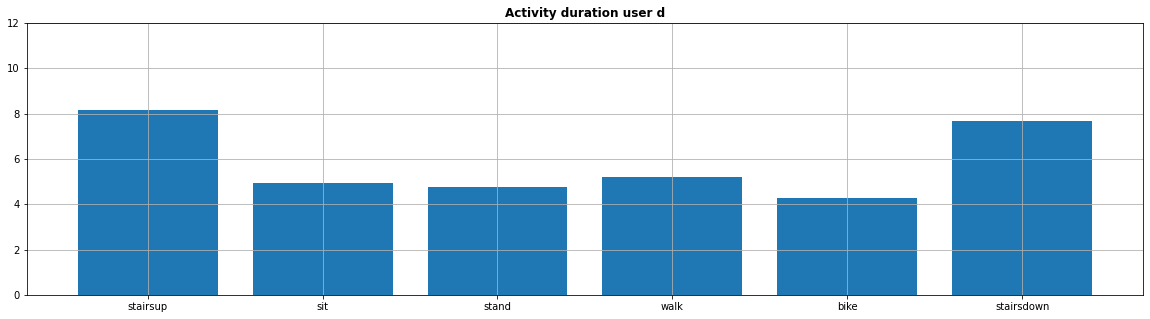

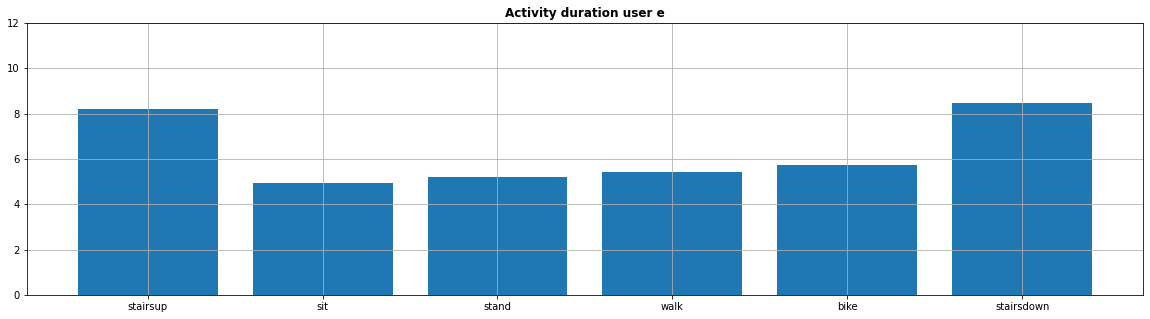

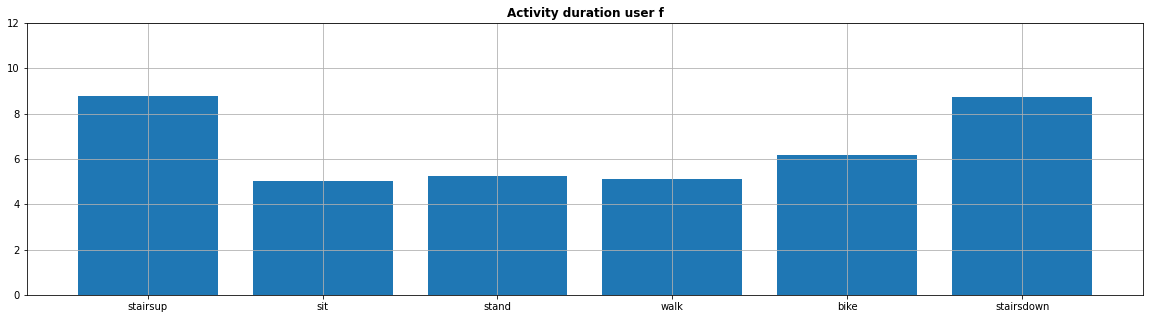

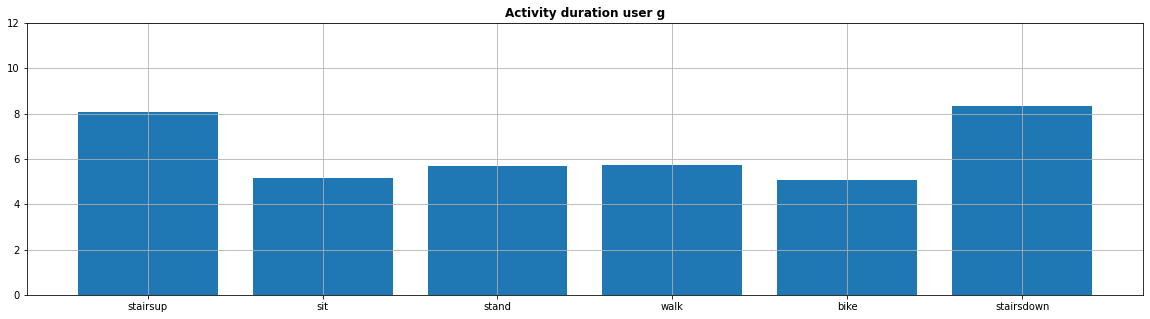

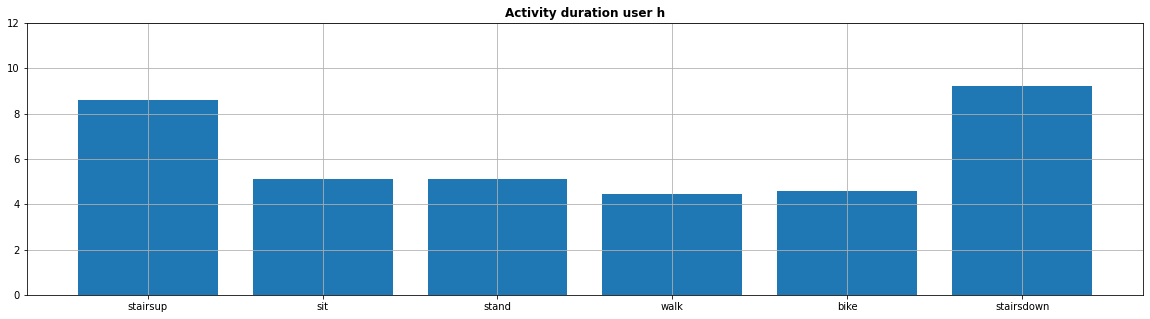

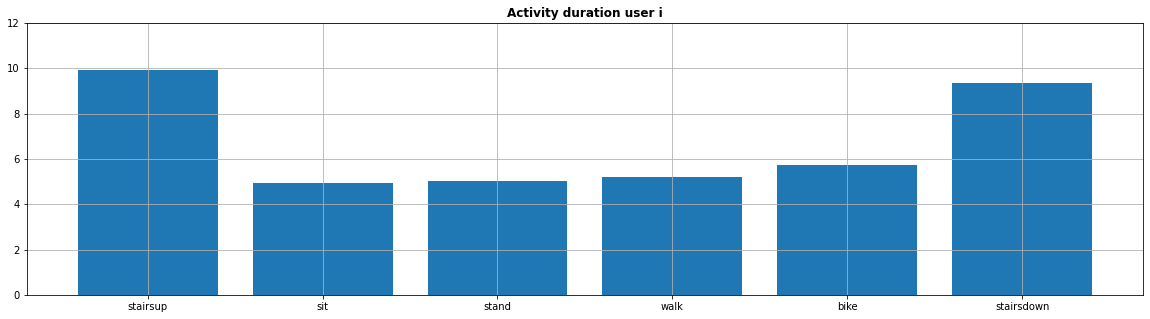

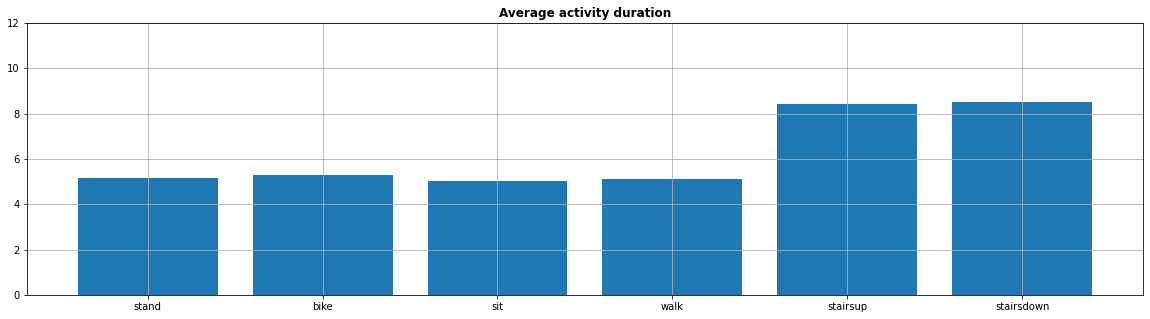

In [ ]:
user = [chr(i) for i in range(97, 106)]
gt = ['stand', 'bike', 'sit', 'stand', 'walk', 'stairsup', 'stairsdown', 'null']
total_data = {key: [] for key in gt}
for u in user:
  user_data = df.filter(f.col('user') == u).select('gt', 'Arrival_Time')
  # print(u)

  user_data = user_data.groupBy("gt") \
    .agg(f.min("Arrival_Time").alias("start"), \
         f.max("Arrival_Time").alias("end"))

  # user_data.show()
  
  user_data = user_data.withColumn\
          ("start",  f.from_unixtime(user_data.start/1000))\
          .withColumn("end",  f.from_unixtime(user_data.end/1000))
  
  x = user_data.collect()
  act_length = {}
  for row in x:
    start = datetime.fromisoformat(row[1])
    end = datetime.fromisoformat(row[2])
    diff = (end - start).total_seconds()
    res = round(diff / 60, 2)
    act_length[row[0]] = res
    total_data[row[0]].append(res)  # recording to calc overall avg

  del act_length['null']
  plot_bar(f'Activity duration user {u}', act_length)

total_data = {key: sum(total_data[key])/len(total_data[key]) for key in total_data}
del total_data['null']
plot_bar(f'Average activity duration', total_data)

**Insight 2 concusion:**

Each activity is performed for a diferent amount of time, which also varies per user. Therefore, our prediction model could keep count of the starting time of the starting time of a predicted activitiy and use this data to continue classifiying the ongoing activity or determine the activity is over.

The 2 activities which their duration was most noticable to differ from the rest are: 'stairsup' and 'stairsdown' which averged over 8 minute duration per activity, while the remaining activities all were averging below 6 minutes per activity.

# **Insight 3**

Checking if theres a certain sequence each user decides to perform their activities. Some people might prefer to bike prior to doing a stairs workout, some might like to sit after every activity... looking for a users pattern.

In [ ]:
def plot_timeline(plot_df, title_):
  fig = px.timeline(plot_df, x_start="start", x_end="end", y="Activity", color="Activity", title=title_)
  fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
  fig.update_yaxes(autorange="reversed")
  fig.show()

In [ ]:
timeline = df.groupBy("User", "gt") \
    .agg(f.min("Arrival_Time").alias("start"), \
         f.max("Arrival_Time").alias("end"))
    
timeline = timeline.sort("User","start")

timeline = timeline.withColumn\
          ("start",  f.from_unixtime(timeline.start/1000))\
          .withColumn("end",  f.from_unixtime(timeline.end/1000))

for i in range(97, 106):
  user = chr(i)  
  user_data = timeline.filter(f.col('user') == user).collect()
  plot_data = []
  for row in user_data:
    if row[1] != 'null':
      plot_data.append({'Activity': row[1], 'start': row[2], 'end': row[3]})

  plot_df = pd.DataFrame(plot_data)
  plot_timeline(plot_df, f"User '{user}' activity timeline")


**Insight 3 conclusion:**

Although there are minor changes in the sequence users decide to perform their activities, we found 2 very interesting insights which can help the ML model predict the activity.

First, all the activities are performed in 1 timeframe, consistently.
(except for 'stairsup' and 'stairsdown', addressed in the next line) 
Second, 'stairsup' and 'stairsdown' are always performed over the same amount of time. Is this just the reading of the sensors or is this an activity which the user goes up stairs and then down stairs and repeats? 
One way or another, by identifying an activity, along with insight 2 - can contribute to the ML model to predict the activity. 